In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional,Activation
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

C:\Users\smuruga3\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\smuruga3\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\smuruga3\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\smuruga3\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWa

In [2]:
# importing the data

df_train = pd.read_csv("train.txt", sep = ";", header=None, names =["Docs", "Emotions"])
df_test = pd.read_csv("test.txt", sep = ";", header=None, names =["Docs", "Emotions"])
df_val = pd.read_csv("val.txt", sep = ";", header=None, names =["Docs", "Emotions"])

In [3]:
# view the data for train, test and validation dataset
print(df_train.head())
print(df_test.head())
print(df_val.head())

                                                Docs Emotions
0                            i didnt feel humiliated  sadness
1  i can go from feeling so hopeless to so damned...  sadness
2   im grabbing a minute to post i feel greedy wrong    anger
3  i am ever feeling nostalgic about the fireplac...     love
4                               i am feeling grouchy    anger
                                                Docs Emotions
0  im feeling rather rotten so im not very ambiti...  sadness
1          im updating my blog because i feel shitty  sadness
2  i never make her separate from me because i do...  sadness
3  i left with my bouquet of red and yellow tulip...      joy
4    i was feeling a little vain when i did this one  sadness
                                                Docs Emotions
0  im feeling quite sad and sorry for myself but ...  sadness
1  i feel like i am still looking at a blank canv...  sadness
2                     i feel like a faithful servant     love
3       

In [4]:
# print the count of the rows for each dataset
print(df_train.count())
print(df_test.count())
print(df_val.count())

Docs        16000
Emotions    16000
dtype: int64
Docs        2000
Emotions    2000
dtype: int64
Docs        2000
Emotions    2000
dtype: int64


In [5]:
# Lets explore the emotions options that we have in this dataset
print(df_train["Emotions"].unique())
print(df_test["Emotions"].unique())
print(df_val["Emotions"].unique())

['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']
['sadness' 'joy' 'fear' 'anger' 'love' 'surprise']
['sadness' 'love' 'anger' 'joy' 'fear' 'surprise']


In [6]:
#Assign the labels to the emotions
x = {'sadness':0,'anger':1,'fear':2,'love':3,'surprise':4,'joy':5}
df_train['label'] = df_train['Emotions'].map(x)
df_test['label'] = df_test['Emotions'].map(x)
df_val['label'] = df_val['Emotions'].map(x)

In [7]:
# assign to y variables
y_train, y_test, y_val = df_train['label'], df_test['label'], df_val['label']

In [8]:
#Label Encoding
le = LabelEncoder()
le.fit(y_train)

encoded_y_train = le.transform(y_train)
encoded_y_test = le.transform(y_test)
encoded_y_val = le.transform(y_val)

encoded_y_train = to_categorical(encoded_y_train)
encoded_y_test = to_categorical(encoded_y_test)
encoded_y_val = to_categorical(encoded_y_val)

print(encoded_y_train)

print(y_train[:10])

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
0    0
1    0
2    1
3    3
4    1
5    0
6    4
7    2
8    5
9    3
Name: label, dtype: int64


In [9]:
# View the labels assigned to emotions in the training dataset
df_train.head()

,Docs,Emotions,label
0,i didnt feel humiliated,sadness,0
1,i can go from feeling so hopeless to so damned...,sadness,0
2,im grabbing a minute to post i feel greedy wrong,anger,1
3,i am ever feeling nostalgic about the fireplac...,love,3
4,i am feeling grouchy,anger,1


In [10]:
# Data Preprocessing - converting all words to lower case
def preprocess_text(column):
    data=[]
    lower =[x.lower() for x in column]
    lower =[x.replace("[^a-zA-Z]", " ") for x in lower]
    for word in lower:
        split = word.split()
        stop_words = set(stopwords.words("english"))
        stopword = [i for i in split if i not in stop_words]
        ps = PorterStemmer()
        stem = [ps.stem(w) for w in stopword] 
        wordnet_lemmatizer = WordNetLemmatizer()
        lemma = [wordnet_lemmatizer.lemmatize(w) for w in stem]
        data.append(lemma)
    return data

In [11]:
# preprocessing the data and creating the clean data column
df_train['clean_data']  = preprocess_text(df_train['Docs'])
df_test['clean_data']  = preprocess_text(df_test['Docs'])
df_val['clean_data']  = preprocess_text(df_val['Docs'])

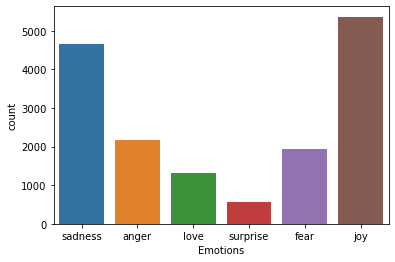

In [12]:
# Plotting for visualization of training data 
df_train['Emotions'].value_counts()
ax = sns.countplot(x="Emotions", data=df_train)

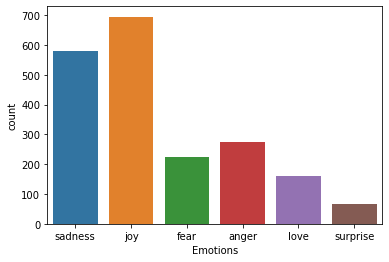

In [13]:
# Plotting for visualization of test data 
df_test['Emotions'].value_counts()
ax = sns.countplot(x="Emotions", data=df_test)

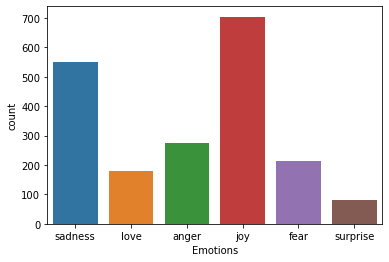

In [14]:
# Plotting for visualization of validation data 
df_val['Emotions'].value_counts()
ax = sns.countplot(x="Emotions", data=df_val)

In [15]:
from wordcloud import WordCloud
def Plotwordcloud(text,title):
    wordcloud = WordCloud(width = 1000, height = 1000, background_color ='White', min_font_size = 3)
    wordcloud.generate(str(text))
    # plot the WordCloud image
    #plt.figure(figsize = (3, 3), facecolor = None)
    plt.imshow(wordcloud)
    plt.title(title, fontdict={'size': 10, 'verticalalignment': 'bottom'})
    plt.axis("off")
    #plt.show()

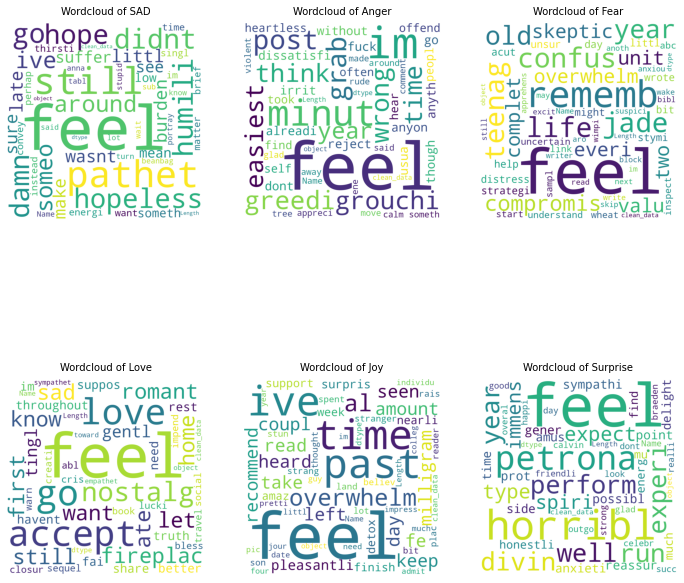

In [16]:
#Lets see the wordcloud
plt.figure(1,figsize=(12, 12))

for i in range(len(df_train["Emotions"].unique())):
    plt.subplot(2,3,i+1)
    if i == 0:
        Plotwordcloud(df_train[df_train.label == 0]['clean_data'], title = "Wordcloud of SAD")
    elif i == 1:
        Plotwordcloud(df_train[df_train.label == 1]['clean_data'], title = "Wordcloud of Anger")
    elif i == 2:
        Plotwordcloud(df_train[df_train.label == 2]['clean_data'], title = "Wordcloud of Fear")
    elif i == 3:
        Plotwordcloud(df_train[df_train.label == 3]['clean_data'], title = "Wordcloud of Love")
    elif i== 4:
        Plotwordcloud(df_train[df_train.label == 4]['clean_data'], title = "Wordcloud of Joy")
    elif i == 5:
        Plotwordcloud(df_train[df_train.label == 5]['clean_data'], title = "Wordcloud of Surprise")

In [17]:
total_text = np.concatenate((np.array(df_train['clean_data']),np.array(df_test['clean_data']),np.array(df_val['clean_data'])),axis=0)

In [18]:
#using tokenizer from tensorflow
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(total_text)

In [19]:
#converting the texts to sequence
x_train = tokenizer.texts_to_sequences(df_train['clean_data'])
x_test = tokenizer.texts_to_sequences(df_test['clean_data'])
x_val = tokenizer.texts_to_sequences(df_val['clean_data'])

In [20]:
total_token = np.concatenate((x_train,x_test,x_val),axis=0)
print(np.mean([len(text) for text in total_token]))

8.28545


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [21]:
list(tokenizer.word_index)[:10]

['feel', 'like', 'im', 'get', 'time', 'know', 'realli', 'make', 'go', 'want']

In [22]:
x_train_pad = pad_sequences(x_train,20) 
x_test_pad = pad_sequences(x_test,20)
x_val_pad = pad_sequences(x_val,20)

In [23]:
print(x_train_pad.shape, encoded_y_train.shape)
print(x_test_pad.shape, encoded_y_test.shape)
print(x_val_pad.shape, encoded_y_val.shape)

(16000, 20) (16000, 6)
(2000, 20) (2000, 6)
(2000, 20) (2000, 6)


In [24]:
model = Sequential()

model.add(Embedding(input_dim=2000,output_dim=100
                   ,input_length=20))

model.add(Bidirectional(LSTM(units=16,return_sequences=True)))

model.add(Bidirectional(LSTM(units=8)))

model.add(Dense(6,activation="softmax"))

model.compile(loss="categorical_crossentropy",optimizer="rmsprop",metrics=["accuracy"])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 100)           200000    
_________________________________________________________________
bidirectional (Bidirectional (None, 20, 32)            14976     
____________________________________________________________

In [25]:
model.fit(x_train_pad, encoded_y_train, nb_epoch = 10, batch_size = 100,  validation_data =(x_val_pad, encoded_y_val), verbose = 2)

Train on 16000 samples, validate on 2000 samples
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
16000/16000 - 14s - loss: 1.4517 - acc: 0.4584 - val_loss: 1.1662 - val_acc: 0.5835
Epoch 2/10
16000/16000 - 11s - loss: 0.9564 - acc: 0.6667 - val_loss: 0.8641 - val_acc: 0.7110
Epoch 3/10
16000/16000 - 10s - loss: 0.6227 - acc: 0.8009 - val_loss: 0.6197 - val_acc: 0.8010
Epoch 4/10
16000/16000 - 11s - loss: 0.4610 - acc: 0.8512 - val_loss: 0.5649 - val_acc: 0.7990
Epoch 5/10
16000/16000 - 11s - loss: 0.3643 - acc: 0.8852 - val_loss: 0.4876 - val_acc: 0.8420
Epoch 6/10
16000/16000 - 11s - loss: 0.3099 - acc: 0.9016 - val_loss: 0.4427 - val_acc: 0.8500
Epoch 7/10
16000/16000 - 11s - loss: 0.2740 - acc: 0.9121 - val_loss: 0.4493 - val_acc: 0.8535
Epoch 8/10
16000/16000 - 11s - loss: 0.2483 - acc: 0.9212 - val_loss: 0.4199 - val_acc: 0.8585
Epoch 9/10
16000/16000 - 11s - loss: 0.2239 - acc: 0.9252 - val_loss: 0.4389 - val_acc: 0.8555
Ep

In [26]:
tf.saved_model.save(model, export_dir ="tmp\saved_model", signatures = None)

INFO:tensorflow:Assets written to: tmp\saved_model\assets


In [27]:
preds = model.predict_classes(x_test_pad)

In [28]:
#Prniting accuracy Score
print("Accuracy Score for LSTM:",accuracy_score(preds,y_test)*100,"%")
print("Classification Report for LSTM:")
print(classification_report(preds,y_test))

Accuracy Score for LSTM: 85.05 %
Classification Report for LSTM:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       572
           1       0.85      0.81      0.83       289
           2       0.77      0.87      0.82       199
           3       0.58      0.78      0.67       119
           4       0.74      0.61      0.67        80
           5       0.92      0.86      0.89       741

    accuracy                           0.85      2000
   macro avg       0.79      0.81      0.79      2000
weighted avg       0.86      0.85      0.85      2000



In [29]:
x_test_new = ["This product is amazing, I didnt expect this"]
x_test_new  = preprocess_text(x_test_new)
x_test_new = tokenizer.texts_to_sequences(x_test_new)
x_test_new = pad_sequences(x_test_new,20)

In [30]:
x_test_new.shape

(1, 20)

In [31]:
preds = model.predict_classes(x_test_new)

#Assign the labels to the emotions

pred = "sadness" if preds == 0 else "anger" if preds== 1 else "Fear" if preds== 2 else "love" if preds== 3 else "surprise" if preds== 4 else "Joy"
print("Sentiment of the statement is", pred)

Sentiment of the statement is Joy


In [38]:
pipe1 = Pipeline([('CV', CountVectorizer()), ('TF-IDF', TfidfTransformer()),('model', LogisticRegression())])
model_lr= pipe1.fit(df_train['Docs'],y_train)
lr_pred = model_lr.predict(df_test['Docs'])
print("Accuracy of Logistic Regression Classifier: {}%".format(round(accuracy_score(y_test, lr_pred)*100,2)))
print(classification_report(y_test, lr_pred))

Accuracy of Logistic Regression Classifier: 86.2%
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       581
           1       0.90      0.81      0.85       275
           2       0.87      0.78      0.82       224
           3       0.82      0.58      0.68       159
           4       0.84      0.47      0.60        66
           5       0.83      0.96      0.89       695

    accuracy                           0.86      2000
   macro avg       0.86      0.75      0.79      2000
weighted avg       0.86      0.86      0.86      2000



C:\Users\smuruga3\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
